# Map Neighborhood
In this notebook, I use the development pipeline data of SF development in order to create an online map of residential construction by PDAs. 


In [19]:
#import packages
import pandas as pd
import numpy as np
import re as re
import json    # library for working with JSON-formatted text strings
import requests  # library for accessing content from web URLs
import pprint  # library for making Python data structures readable
pp = pprint.PrettyPrinter()
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
from geopy.distance import great_circle
# magic command to display matplotlib plots inline within the ipython notebook
%matplotlib inline

pd.options.display.float_format = '{:.2f}'.format #display series descriptions in normal format (i.e. not scientific notation)

In [20]:
#specify file paths
import_path = '../../Intermediate Files'
code_path = '../../Code/Maps/'

# Section 1: Create polygons with recently completed development

## Determine constructed units over time

First, I assume that units were constructed in the latest quarter for which the project had "construction" as a project status. I identify these observations.

In [21]:
full_df = pd.read_csv(import_path+"/pipeline.csv")

In [22]:
#(03/02/2016) dropping Hunters Point shipyard until more robust solution. See Github issues for further explanation
full_df = full_df[full_df['address'] != 'HUNTERS POINT SHIPYARD, PHASE II']

In [23]:
#create dataframe for construction ending over time. This is a method to identify where construction ended,
#at which point the data drops out of the pipeline
cons_end = full_df[full_df['status'] == "CONSTRUCTION"].groupby(['lot_number'], as_index=False)['quarter_order'].max()
cons_end.rename(columns = {'quarter_order': 'consdate'}, inplace = True)
#merge data together to identify quarter that projects were built
full_df2 = full_df.merge(cons_end, on = 'lot_number', how = "outer")
full_df2 = full_df2[full_df2['consdate'] == full_df2['quarter_order']]
full_df2 = full_df2[full_df2['quarter_order'] != 19]

## Create Point Data

In [24]:
crs = {'init' :'epsg:4326'}
geometry = [Point(xy) for xy in zip(full_df2.lon, full_df2.lat)]
construction = GeoDataFrame(full_df2, crs=crs, geometry=geometry)
#construction.plot();

In [25]:
construction.head()

,Unnamed: 0,address,affordable_units,cie,cie_net,comm_sqft,comm_sqft_net,desc,ind,ind_net,...,status,units,vis,vis_net,zone,lon,lat,quarter_order,consdate,geometry
16,940,721 BEACH ST,0.00,nan,nan,5589.00,5589.00,"TO ERECT 3 STORIES, 1 UNIT RESIDENTIAL / COMME...",nan,nan,...,CONSTRUCTION,1.00,nan,nan,C-2,-122.42,37.81,14,14.00,POINT (-122.42095 37.806318)
41,1195,827 NORTH POINT ST,0.00,nan,nan,0.00,0.00,ERECT NEW 4-STORY 3 DWELLING UNITS CONDO.,nan,nan,...,CONSTRUCTION,3.00,nan,nan,RH-3,-122.42,37.81,16,16.00,POINT (-122.420870283 37.805369032)
143,159,853 LOMBARD ST,0.00,nan,nan,0.00,0.00,"REVISE PA 2015-08-19-4706, CREATE 3RD UNIT- ch...",nan,nan,...,CONSTRUCTION,3.00,nan,nan,RM-1,-122.42,37.80,18,18.00,POINT (-122.415517 37.802228)
299,373,1945 Hyde St,nan,nan,nan,0.00,0.00,SITE PERMIT - CHANGE OF USE FROM PARKING GARAG...,nan,nan,...,CONSTRUCTION,7.00,nan,nan,NC-1,-122.42,37.80,9,9.00,POINT (-122.419267 37.798827)
323,754,778 VALLEJO ST,0.00,nan,nan,0.00,0.00,PROPOSED CONVERSION OF (E) STORAGE TO CONDITIO...,nan,nan,...,CONSTRUCTION,3.00,nan,nan,NCD,-122.41,37.80,14,14.00,POINT (-122.410102 37.798608)


## Import PDA Boundaries

In [26]:
root = '../../Raw Data'
boundaries = gpd.read_file(root+'/PDAs/PDAs.shp')

In [27]:
boundaries.head(10)

,abagstatus,fipco,futurept1,geometry,grossacres,joinkey,lead,name,netacres,planstatus,subregion
0,Final,6001,Mixed-Use Corridor,"POLYGON ((564538.7888000013 4190839.092299999,...",21.21,BER4,Berkeley,South Shattuck,15.74,Planned,None
1,Final,6001,Transit Town Center,"POLYGON ((576838.6746000003 4173612.5673, 5767...",168.57,SLE1,San Leandro,Bay Fair Bay Area Rapid Transit Village,132.84,Potential,None
2,Final,6001,Suburban Center,"POLYGON ((609334.0837999997 4171696.5306, 6093...",252.26,LIV1,Livermore,Downtown,199.94,Planned,None
3,Final,6001,City Center,"POLYGON ((563510.1734999998 4187195.755100001,...",583.96,EME1,Emeryville,Mixed-Use Core,451.34,Planned,None
4,Final,6001,City Center,"POLYGON ((586837.7620000003 4161493.234300001,...",142.97,UNI1,Union City,Intermodal Station District,129.46,Planned,None
5,Final,6001,Mixed-Use Corridor,"POLYGON ((564307.4911999996 4189799.324600001,...",62.14,BER1,Berkeley,Adeline Street,41.93,Potential,None
6,Final,6001,Suburban Center,"POLYGON ((601211.9889999997 4174629.0152, 6011...",675.84,DUB3,Dublin,Town Center,546.22,Planned,None
7,Final,6001,Suburban Center,"POLYGON ((598426.6127999998 4173245.5955, 5984...",869.21,PLE1,Pleasanton,Hacienda,733.11,Potential,None
8,Final,6001,Suburban Center,"POLYGON ((594865.2683999999 4173924.7032, 5948...",300.36,DUB1,Dublin,Downtown Specific Plan Area,249.02,Planned,None
9,Final,6001,Suburban Center,"POLYGON ((597541.332199999 4174527.5897, 59754...",279.59,DUB2,Dublin,Transit Center/Dublin Crossings,244.94,Planned,None


In [28]:
#Keep only PDAs in SF
boundaries = boundaries[boundaries['lead']=='San Francisco']
#Dropping Treasure Island for now
boundaries = boundaries[boundaries['name']!='Treasure Island & Yerba Buena Island']

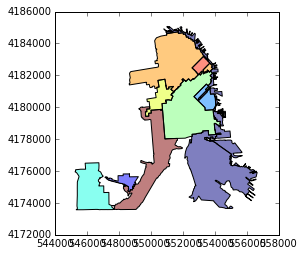

In [29]:
boundaries.plot()

In [30]:
#convert boundaries to geographic coordinate system to conform to points
boundaries = boundaries.to_crs({'init': 'epsg:4326'}) 

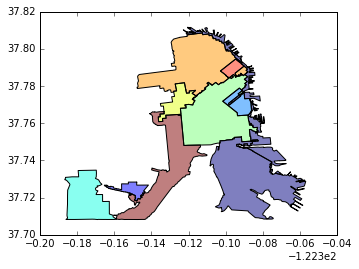

In [31]:
boundaries.plot()

In [32]:
boundaries.head()

,abagstatus,fipco,futurept1,geometry,grossacres,joinkey,lead,name,netacres,planstatus,subregion
123,Final,6075,Mixed-Use Corridor,(POLYGON ((-122.3709869998455 37.7333309997252...,811.33,SFO6,San Francisco,Port of San Francisco,677.81,Planned,None
124,Final,6075,Transit Neighborhood,"POLYGON ((-122.447916931002 37.7282174885926, ...",207.29,SFO2,San Francisco,Balboa Park,136.30,Planned,None
125,Final,6075,Urban Neighborhood,POLYGON ((-122.3912231544804 37.77747172378415...,290.48,SFO5,San Francisco,Mission Bay,238.40,Planned,None
126,Final,6075,Transit Town Center,"POLYGON ((-122.458905755934 37.70849256750056,...",1163.14,SFO10,San Francisco,19th Avenue,893.44,Potential,None
127,Final,6075,Urban Neighborhood,(POLYGON ((-122.390457615822 37.77686101235072...,2291.40,SFO4,San Francisco,Eastern Neighborhoods,1632.28,Planned,None


## Combine Layers

In [33]:
#First, spatial join between points and neighborhood boundaries. Set 'how' to 'right' to preserve polygon geometries.
nbcum = gpd.sjoin(construction, boundaries, how = 'right', op='within')

In [34]:
#Next, dissolve by neighborhoods to get sum of units
nbcum = nbcum[['name', 'geometry', 'net_units', 'net_affordable_units']]
nb_map = nbcum.dissolve(by=['name'], aggfunc='sum')

nb_map['net_units'].fillna(0, inplace = True)
nb_map['net_affordable_units'].fillna(0, inplace = True)

nb_map['net_units'] = nb_map['net_units'].astype(int)
nb_map['net_affordable_units'] = nb_map['net_affordable_units'].astype(int)

nb_map['name']=nb_map.index

In [36]:
#Define function to create categories for javascript maps. Each category will be separate dot color
def cats(value):
    if (value['net_units'] >=0) & (value['net_units']<=50): 
        field = 0
        
    elif (value['net_units'] >=51) & (value['net_units']<=200):
        field = 1
        
    elif (value['net_units'] >=201) & (value['net_units']<=500):
        field = 2
        
    elif (value['net_units'] >=501) & (value['net_units']<=2000):
        field = 3
    else: 
        field = 4
        
    return field


nb_map['unitcat'] = nb_map.apply(cats, axis = 1)

In [37]:
#make variables into a string with commas before export
nb_map['net_units'] = nb_map['net_units'].astype(int)
nb_map['net_units'] = nb_map['net_units'].map(lambda x: '{:,}'.format(x), na_action='ignore')

In [38]:
#export to geojson object
export_path = code_path
with open(export_path+'/Neighborhood Maps/nbPDA_recent.js', 'w') as f:
    f.write('var dataset9 = {};'.format(nb_map.to_json()))

# Section 2: Create polygons with currently proposed development only

In [39]:
#isolate currently proposed development
current = full_df[full_df['quarter']=='Q1-2017']

In [40]:
#create geodataframe for current development
crs = {'init' :'epsg:4326'}
geometry = [Point(xy) for xy in zip(current.lon, current.lat)]
current_geo = GeoDataFrame(current, crs=crs, geometry=geometry)

In [41]:
#First, spatial join between points and neighborhood boundaries. Set 'how' to 'right' to preserve polygon geometries.
final_geo = gpd.sjoin(current_geo, boundaries, how = 'right', op='within')

In [42]:
#Next, dissolve by neighborhoods to get sum of units
final_geo = final_geo[['name', 'geometry', 'net_units', 'net_affordable_units']]
final_geo = final_geo.dissolve(by=['name'], aggfunc='sum')

final_geo['net_units'].fillna(0, inplace = True)
final_geo['net_affordable_units'].fillna(0, inplace = True)

final_geo['net_units'] = final_geo['net_units'].astype(int)
final_geo['net_affordable_units'] = final_geo['net_affordable_units'].astype(int)

final_geo['name']=final_geo.index

In [43]:
#Define function to create categories for javascript maps. Each category will be separate dot color
def cats(value):
    if (value['net_units'] >=0) & (value['net_units']<=50): 
        field = 0
        
    elif (value['net_units'] >=51) & (value['net_units']<=200):
        field = 1
        
    elif (value['net_units'] >=201) & (value['net_units']<=500):
        field = 2
        
    elif (value['net_units'] >=501) & (value['net_units']<=2000):
        field = 3
    else: 
        field = 4
        
    return field


final_geo['unitcat'] = final_geo.apply(cats, axis = 1)

In [44]:
#make variables into a string with commas before export
final_geo['net_units'] = final_geo['net_units'].astype(int)
final_geo['net_units'] = final_geo['net_units'].map(lambda x: '{:,}'.format(x), na_action='ignore')

In [45]:
#export to geojson object
export_path = code_path
with open(export_path+'/Neighborhood Maps/nbPDA_current.js', 'w') as f:
    f.write('var dataset10 = {};'.format(final_geo.to_json()))

# Section 3. Create Polygons with Non-residential development - recently completed

In [46]:
#import commercial development data
nr_df = pd.read_csv(import_path+"/pipeline_com.csv")

In [47]:
#some initial cleaning
vars = ['comm_sqft', 'comm_sqft_net']
#do some initial data cleaning
for item in vars:
    nr_df[item] = nr_df[item].fillna(0)

In [48]:
#create dataframe for construction ending over time. This is a method to identify where construction ended,
#at which point the data drops out of the pipeline
cons_end_nr = nr_df[nr_df['status'] == "CONSTRUCTION"].groupby(['lot_number'], as_index=False)['quarter_order'].max()
cons_end_nr.rename(columns = {'quarter_order': 'consdate'}, inplace = True)
#merge data together to identify quarter that projects were built
nr_df2 = nr_df.merge(cons_end_nr, on = 'lot_number', how = "outer")
nr_df2 = nr_df2[nr_df2['consdate'] == nr_df2['quarter_order']]
nr_df2 = nr_df2[nr_df2['quarter_order'] != 19]

In [49]:
#create geodataframe for current development
crs = {'init' :'epsg:4326'}
geometry = [Point(xy) for xy in zip(nr_df2.lon, nr_df2.lat)]
nr_geo = GeoDataFrame(nr_df2, crs=crs, geometry=geometry)

In [50]:
#First, spatial join between points and neighborhood boundaries. Set 'how' to 'right' to preserve polygon geometries.
final_geo = gpd.sjoin(nr_geo, boundaries, how = 'right', op='within')

In [51]:
#Next, dissolve by neighborhoods to get sum of units
final_geo = final_geo[['name', 'geometry', 'comm_sqft_net', 'comm_sqft']]
final_geo = final_geo.dissolve(by=['name'], aggfunc='sum')

final_geo['comm_sqft'].fillna(0, inplace = True)
final_geo['comm_sqft_net'].fillna(0, inplace = True)

final_geo['comm_sqft'] = final_geo['comm_sqft'].astype(int)
final_geo['comm_sqft_net'] = final_geo['comm_sqft_net'].astype(int)

final_geo['name']=final_geo.index

In [52]:
final_geo['comm_sqft_net'].describe(percentiles = [.05, .1, .2, .3, .4, .5, .6, .7, .8, .9, .95])

count        10.00
mean     427532.00
std      744705.29
min     -353860.00
5%      -194623.00
10%      -35386.00
20%        6368.00
30%       10773.30
40%       78135.60
50%      186846.00
60%      256471.20
70%      322673.40
80%      660956.60
90%     1524373.90
95%     1784936.95
max     2045500.00
Name: comm_sqft_net, dtype: float64

In [53]:
#Define function to create categories for javascript maps. Each category will be separate dot color
def cats(value):
    if value['comm_sqft_net'] < -5000: 
        field = 0
        
    elif (value['comm_sqft_net'] >= -5000) & (value['comm_sqft_net']< 0):
        field = 1
        
    elif (value['comm_sqft_net'] >= 0) & (value['comm_sqft_net'] <= 5000):
        field = 2
        
    elif (value['comm_sqft_net'] >= 5001) & (value['comm_sqft_net'] <= 10000):
        field = 3
        
    elif (value['comm_sqft_net'] >=10001) & (value['comm_sqft_net'] <= 50000):
        field = 4  
        
    else: 
        field = 5
        
    return field


final_geo['unitcat'] = final_geo.apply(cats, axis = 1)

In [54]:
#make variables into a string with commas before export
final_geo['comm_sqft_net'] = final_geo['comm_sqft_net'].astype(int)
final_geo['comm_sqft_net'] = final_geo['comm_sqft_net'].map(lambda x: '{:,}'.format(x), na_action='ignore')

In [55]:
#export to geojson object
export_path = code_path
with open(export_path+'/Neighborhood Maps/nbPDA_comm.js', 'w') as f:
    f.write('var dataset11 = {};'.format(final_geo.to_json()))

# Section 4. Create Polygons with Non-residential development -currently proposed

In [56]:
#isolate currently proposed development
current = nr_df[nr_df['quarter']=='Q1-2017']

In [57]:
#create geodataframe for current development
crs = {'init' :'epsg:4326'}
geometry = [Point(xy) for xy in zip(current.lon, current.lat)]
current_geo = GeoDataFrame(current, crs=crs, geometry=geometry)

In [58]:
#First, spatial join between points and neighborhood boundaries. Set 'how' to 'right' to preserve polygon geometries.
final_geo = gpd.sjoin(current_geo, boundaries, how = 'right', op='within')

In [59]:
#Next, dissolve by neighborhoods to get sum of units
final_geo = final_geo[['name', 'geometry', 'comm_sqft_net', 'comm_sqft']]
final_geo = final_geo.dissolve(by=['name'], aggfunc='sum')

final_geo['comm_sqft'].fillna(0, inplace = True)
final_geo['comm_sqft_net'].fillna(0, inplace = True)

final_geo['comm_sqft'] = final_geo['comm_sqft'].astype(int)
final_geo['comm_sqft_net'] = final_geo['comm_sqft_net'].astype(int)

final_geo['name']=final_geo.index

In [60]:
#Define function to create categories for javascript maps. Each category will be separate dot color
def cats(value):
    if value['comm_sqft_net'] < -5000: 
        field = 0
        
    elif (value['comm_sqft_net'] >= -5000) & (value['comm_sqft_net']< 0):
        field = 1
        
    elif (value['comm_sqft_net'] >= 0) & (value['comm_sqft_net'] <= 5000):
        field = 2
        
    elif (value['comm_sqft_net'] >= 5001) & (value['comm_sqft_net'] <= 10000):
        field = 3
        
    elif (value['comm_sqft_net'] >=10001) & (value['comm_sqft_net'] <= 50000):
        field = 4  
        
    else: 
        field = 5
        
    return field


final_geo['unitcat'] = final_geo.apply(cats, axis = 1)

In [61]:
#make variables into a string with commas before export
final_geo['comm_sqft_net'] = final_geo['comm_sqft_net'].astype(int)
final_geo['comm_sqft_net'] = final_geo['comm_sqft_net'].map(lambda x: '{:,}'.format(x), na_action='ignore')

In [62]:
#export to geojson object
export_path = code_path
with open(export_path+'/Neighborhood Maps/nbPDA_comm_curr.js', 'w') as f:
    f.write('var dataset12 = {};'.format(final_geo.to_json()))

In [ ]:
final_geo.head()